# Анализ пользовательского поведения в мобильном приложении

Необходимо разобраться, как ведут себя пользователи мобильного приложения для продажи продуктов питания. Для этого нужно изучить путь пользователя в приложении и построить воронку продаж. 

Во второй части проекта необходимо исследовать результаты A/A/B-эксперимента. Проверялась гипотеза о том, что изменение шрифтов в приложении улучшит конверсию пользователей в покупателей. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

Результаты эксперимента хранятся в логе, в котором каждая запись это действие пользователя или событие:

* `EventName` - название события;
* `DeviceIDHash`- уникальный идентификатор пользователя;
* `EventTimestamp` - время события;
* `ExpId` - номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Задачи:**

1. Изучить путь пользователя до покупки (воронку продаж).
2. Определить, на каких шагах «застревает» наибольшее количество пользователей.
3. По результатам A/A/B-эксперимента опеределить, стоит ли менять шрифты в приложении.

**План исследования:**

**1.** Обзор и предобработка данных

**2.** Проверка данных

**3.** Изучение воронки событий:

* Выстраивание воронки продаж
* Рассчет общей конверсии для каждого шага
* Рассчет конверсии в шаг

**4.** Анализ результатов A/A/B-эксперимента
    



### Обзор данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [4]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('logs_exp.csv', sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нет.

### Предобработка данных

**Скорректируем названия столбцов**

In [6]:
data = data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 
                            'EventTimestamp': 'event_dt', 'ExpId': 'group'})
data.columns

Index(['event_name', 'user_id', 'event_dt', 'group'], dtype='object')

**Преобразуем формат даты в формат datetime и добавим отдельный столбец с датой.**

In [7]:
data['event_dt'] = pd.to_datetime(data['event_dt'], unit='s', origin='unix')
data['dt'] = data['event_dt'].dt.date

In [8]:
data.head()

,event_name,user_id,event_dt,group,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Изучение и проверка данных

**Проверим, есть ли в данных явные дубликаты.**

In [9]:
data.duplicated().sum()

413

Удалим явные дубликаты из данных

In [10]:
data = data .drop_duplicates().reset_index(drop=True)
# check
data.duplicated().sum()

0

**Проверим, не попали ли пользователи с одним id в разные групппы.**

In [11]:
group_246 = pd.Series(data[data['group'] == 246]['user_id'].unique(), name='user_id')
group_247 = pd.Series(data[data['group'] == 247]['user_id'].unique(), name='user_id')
group_248 = pd.Series(data[data['group'] == 248]['user_id'].unique(), name='user_id')
users_unique = pd.concat([group_246, group_247, group_248], axis=0)
print(f'Количество пользователей, попавших в несколько групп {users_unique.duplicated().sum()}')

Количество пользователей, попавших в несколько групп 0


Пользователей, оказавшихся одновременно в нескольких группах, в данных нет.

**Посмотрим, какое количество пользователей в логе и сколько уникальных событий зафиксировали.**

In [12]:
print(f'Всего пользователей: {len(data["user_id"].unique())}')
print(f'Всего событий в логе: {len(data["event_name"].unique())}')

Всего пользователей: 7551
Всего событий в логе: 5


**Посмотрим, сколько событий приходится на пользователя в среднем.**

In [13]:
events_per_user = data.groupby('user_id').agg({'event_name': 'count'}).reset_index()
events_per_user.columns = ['user_id', 'events']

Посмотрим как распределено количество событий на пользователя.

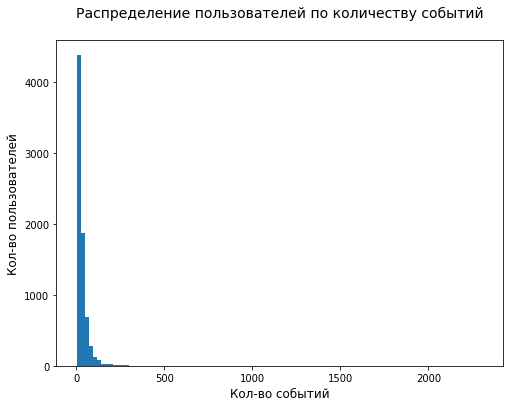

In [14]:
plt.figure(figsize=(8,6))
plt.hist(events_per_user['events'], bins=100)
plt.title('Распределение пользователей по количеству событий\n', fontsize=14)
plt.xlabel('Кол-во событий', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12);

Большинство значений количества событий на пользователя находятся в пределах 50, при этом есть аномально большие значения, например, более 2000 событий на пользователя. Чтобы корректно опеределить сколько событий приходится в среднем на пользователя, необходимо вычислить медиану, что позволит избежать влияния аномально больших значений на вычисления.

In [15]:
print(f'Медианное количество событий на пользователя: {round(events_per_user["events"].median(), 2)}')

Медианное количество событий на пользователя: 20.0


**Определим данными за какой период мы располагаем.**

In [16]:
min_analysis_date = data['event_dt'].min()
max_analysis_date = data['event_dt'].max()
print(min_analysis_date, max_analysis_date, sep='\n')

2019-07-25 04:43:36
2019-08-07 21:15:17


В логе событий представлены данные за две недели.

Построим гистограмму, отображающую количество фиксируемых событий по дням.

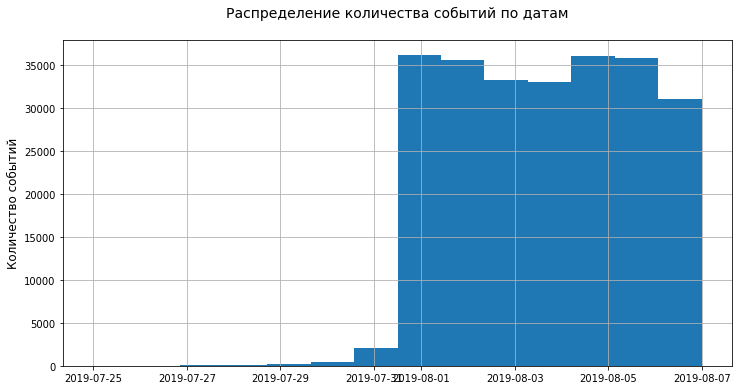

In [17]:
plt.figure(figsize=(12,6))
data['dt'].hist(bins=14)
plt.title('Распределение количества событий по датам\n', fontsize=14)
plt.ylabel('Количество событий', fontsize=12);

Количество фиксируемых событий резко возрастает 1 августа, спустя неделю после начала регистрации данных. Это связано с тем, что информация о событии может доходить с опозданием. Таким образом, наиболее полные данные были собраны за период с 1 по 7 августа, их мы и оставим для дальнейшего анализа. 

**Отбросим данные за конец июня и проверим, сколько событий и пользователей оказалось в отброшенных данных.**

In [18]:
initial_data_shape = data.shape[0]
initial_data_users = len(data['user_id'].unique())
filtered_data = data.query('dt > datetime(2019, 7, 31).date()')
filtered_data_shape = filtered_data.shape[0]
filtered_data_users = len(filtered_data['user_id'].unique())
print(f'Количество потерянных событий = {initial_data_shape - filtered_data_shape}')
print(f'Количество потерянных событий (%) = {round((1 - filtered_data_shape/initial_data_shape) * 100, 2)}%')
print(f'Количество потерянных пользователей = {initial_data_users - filtered_data_users}')
print(f'Количество потерянных событий (%) = {round((1 - filtered_data_users/initial_data_users) * 100, 2)}%')

Количество потерянных событий = 2826
Количество потерянных событий (%) = 1.16%
Количество потерянных пользователей = 17
Количество потерянных событий (%) = 0.23%


В процессе фильтрации было отброшено 1,16% событий и 0,23% пользователей от общего количества, что не должно сказаться на качестве анализа, так как количество отброшенных данных минимально по сравнению с общей выборкой.

**Посмотрим, как распределено количество пользователей по группам.**

In [19]:
users_number = filtered_data.groupby('group', as_index=False).agg({'user_id': 'nunique'})
users_number.columns = ['group', 'users_number']
users_number

,group,users_number
0,246,2484
1,247,2513
2,248,2537


В каждой из трех групп есть пользователи, при этом выборки распределились достаточно равномерно.

### Изучение воронки событий

#### Посмотрим, сколько раз зафиксировали каждое из событий.

In [20]:
event_grouped = filtered_data.groupby('event_name', as_index=False).agg({'user_id': 'count'})
event_grouped.columns = ['event_name', 'events_number']
event_grouped.sort_values(by='events_number', ascending=False).style.format({'events_number': '{:,.0f}'})

,event_name,events_number
1,MainScreenAppear,"117,328"
2,OffersScreenAppear,"46,333"
0,CartScreenAppear,"42,303"
3,PaymentScreenSuccessful,"33,918"
4,Tutorial,"1,005"


Наиболее популярным является событие просмотра главного экрана, наиболее редким оказалось событие просмотра тьюториала.

#### Посмотрим, сколько пользователей совершили каждое из событий.

Также рассчитаем конверсию общего количества уникальных пользователей в каждый шаг.

In [21]:
user_num_per_event = filtered_data.groupby('event_name', as_index=False).agg({'user_id': 'nunique'})
user_num_per_event.columns = ['event_name', 'users_number']
user_num_per_event['conversion'] = user_num_per_event['users_number'] / filtered_data_users
user_num_per_event = user_num_per_event.sort_values(by='users_number', ascending=False).reset_index(drop=True)
user_num_per_event.style.format({'conversion': '{:.2%}'})

,event_name,users_number,conversion
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


Практически все пользователи просматривали главную страницу, 61% пользователей видели страницу с предложением, около 50% пользователей заходили в корзину и успешну совершили покупку. Тьюториал просмотрели 11% пользователей.

Воронка событий выстраивается следующим образом: `появление главного экрана` &rarr; `появление страницы с предложением` &rarr; `появление страницы с корзиной` &rarr; `появление страницы с сообщением об успешной оплате`. Шаг с просмотром обучения не является обязательным и многие пользователи его пропускали, поэтому в воронке его быть не должно.

In [22]:
user_num_per_event = user_num_per_event.drop([4], axis=0)

#### Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [23]:
user_num_per_event['previous_step_users'] = user_num_per_event['users_number'].shift(1)
user_num_per_event = user_num_per_event.fillna(user_num_per_event['users_number'][0])
user_num_per_event['conversion_in_step'] = user_num_per_event['users_number'] / user_num_per_event['previous_step_users']
user_num_per_event = user_num_per_event.drop(['previous_step_users'], axis=1)
user_num_per_event.style.format({'conversion': '{:.2%}', 'conversion_in_step': '{:.2%}'})

,event_name,users_number,conversion,conversion_in_step
0,MainScreenAppear,7419,98.47%,100.00%
1,OffersScreenAppear,4593,60.96%,61.91%
2,CartScreenAppear,3734,49.56%,81.30%
3,PaymentScreenSuccessful,3539,46.97%,94.78%


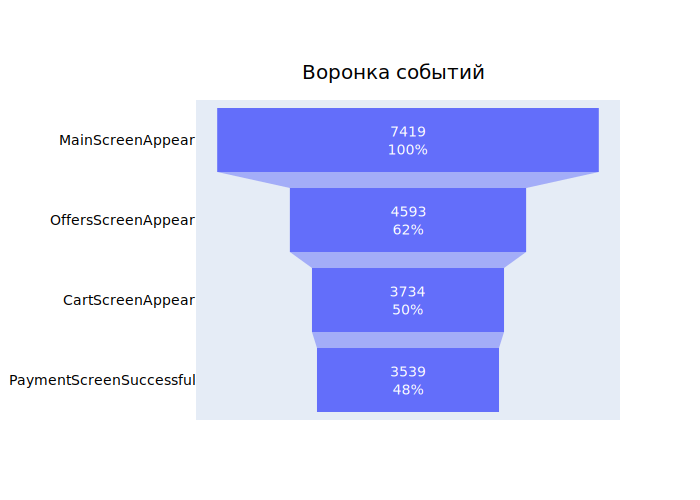

In [24]:
fig = go.Figure(go.Funnel(
    y = list(user_num_per_event['event_name'].unique()),
    x = list(user_num_per_event['users_number'].unique()),
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(
    title={
        'text': "Воронка событий",
        'y':0.87,
        'x':0.562,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
        size=14,
        color='Black'
    )
)

fig.show("svg")

Наибольшая потеря пользователей - около 38% - происходит при переходе в шаг `просмотр страницы предложения`. Возможно для данных пользователей предложение оказалось не таким привлекательным, чтобы продолжить покупки.

#### Посмотрим, какая доля пользователей доходит от первого шага в воронке событий до оплаты покупки.

In [25]:
print(f'До оплаты покупки доходит \
{round((user_num_per_event["users_number"].iloc[-1] / user_num_per_event["users_number"].iloc[0]) * 100, 2)}% пользователей.')

До оплаты покупки доходит 47.7% пользователей.


Примерно половина пришедших в приложение пользователей доходит до покупки, что является достаточно высоким показателем.

#### Рассмотрим воронку событий для каждой из групп по отдельности.

In [26]:
def events_funnel_by_group(data: pd.DataFrame, group_num: list, display_table=True) -> pd.DataFrame:
    group_data = data.query('group in @group_num')
    group_data_funnel = group_data.groupby('event_name', as_index=False).agg({'user_id': 'nunique'})
    group_data_funnel.columns = ['event_name', 'users_number']
    # подсчет общей конверсии
    group_data_funnel['conversion'] = group_data_funnel['users_number'] / len(group_data['user_id'].unique())
    # подсчет конверсии в шаг
    group_data_funnel = group_data_funnel.sort_values(by='users_number', ascending=False).reset_index(drop=True)
    group_data_funnel['previous_step_users'] = group_data_funnel['users_number'].shift(1)
    group_data_funnel = group_data_funnel.fillna(group_data_funnel['users_number'][0])
    group_data_funnel['conversion_in_step'] = group_data_funnel['users_number'] / group_data_funnel['previous_step_users']
    group_data_funnel = group_data_funnel.drop(['previous_step_users'], axis=1)
    if display_table:
        display(group_data_funnel.iloc[0:4].style.format({'conversion': '{:.2%}', 'conversion_in_step': '{:.2%}', \
                                               'previous_step_users': '{:.0f}'}))
    return group_data_funnel

In [27]:
events_funnel_246 = events_funnel_by_group(data=filtered_data, group_num=[246])
events_funnel_247 = events_funnel_by_group(data=filtered_data, group_num=[247])
events_funnel_248 = events_funnel_by_group(data=filtered_data, group_num=[248])

,event_name,users_number,conversion,conversion_in_step
0,MainScreenAppear,2450,98.63%,100.00%
1,OffersScreenAppear,1542,62.08%,62.94%
2,CartScreenAppear,1266,50.97%,82.10%
3,PaymentScreenSuccessful,1200,48.31%,94.79%


,event_name,users_number,conversion,conversion_in_step
0,MainScreenAppear,2476,98.53%,100.00%
1,OffersScreenAppear,1520,60.49%,61.39%
2,CartScreenAppear,1238,49.26%,81.45%
3,PaymentScreenSuccessful,1158,46.08%,93.54%


,event_name,users_number,conversion,conversion_in_step
0,MainScreenAppear,2493,98.27%,100.00%
1,OffersScreenAppear,1531,60.35%,61.41%
2,CartScreenAppear,1230,48.48%,80.34%
3,PaymentScreenSuccessful,1181,46.55%,96.02%


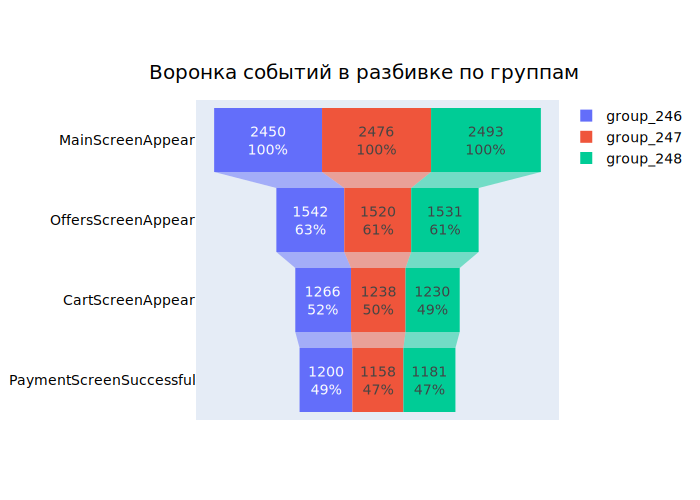

In [37]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group_246',
    y = list(events_funnel_246['event_name'][0:4]),
    x = list(events_funnel_246['users_number'][0:4]),
    textinfo = "value+percent initial")
)

fig.add_trace(go.Funnel(
    name = 'group_247',
    orientation = "h",
    y = list(events_funnel_247['event_name'][0:4]),
    x = list(events_funnel_247['users_number'][0:4]),
    textposition = "inside",
    textinfo = "value+percent initial")
)

fig.add_trace(go.Funnel(
    name = 'group_248',
    orientation = "h",
    y = list(events_funnel_248['event_name'][0:4]),
    x = list(events_funnel_248['users_number'][0:4]),
    textposition = "inside",
    textinfo = "value+percent initial")
)

fig.update_layout(
    title={
        'text': "Воронка событий в разбивке по группам",
        'y':0.87,
        'x':0.52,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
        size=14,
        color='Black'
    )
)

fig.show("svg")

При рассмотрении каждой группы в отдельности в целом картина не меняется. Больше всего пользователей тяряется при переходе на шаг `просмотр страницы предложения`.

### Анализ результатов A/A/B-эксперимента

#### Посмотрим, сколько пользователей в каждой группе

In [29]:
users_number = filtered_data.groupby('group', as_index=False).agg({'user_id': 'nunique'})
users_number.columns = ['group', 'users_number']
users_number

,group,users_number
0,246,2484
1,247,2513
2,248,2537


#### Посмотрим, есть ли статистически значимые различия между контрольными группами. 
Если между контрольными группами будут различия, то результаты эксперимента могут быть искажены, так как пользователи распределились между группами неравномерно (есть отличия в каком-то значимом признаке).

С помощью Z-критерия, выясним есть ли различия между контрольными группами. 

Уровень значимости необходимо рассчитать с учетом поправки на множественные сравнения. Для этого воспользуемся методом Шидака, при этом количество сравнений будет равно 20 (так как всего сравнений будет 20), а $\alpha$&nbsp;=&nbsp;0,05.

Гипотезы:
```
H_0: Различий между группами нет.
H_1: Различия в группах есть.
```

In [30]:
alpha = 0.05
experiments_num = 20
# метод Шидака
alpha_m = round(1 - np.power((1 - alpha), (1 / experiments_num)), 5)
print(f'Уровень значимости с поправкой = {alpha_m}')

Уровень значимости с поправкой = 0.00256


In [31]:
def group_comparison(users_quantity: pd.DataFrame, group_1_num: list, group_2_num: list,
                    group_1: pd.DataFrame, group_2: pd.DataFrame, ):
    group_1_size = users_quantity.query('group in @group_1_num')['users_number'].sum()
    group_2_size = users_quantity.query('group in @group_2_num')['users_number'].sum()
    nobs = list([group_1_size, group_2_size])
    for i in range(len(group_1['event_name'])):
        count = [group_1['users_number'][i], group_2['users_number'][i]]
        stat, pval = proportions_ztest(count, nobs)
        print(f'Сравнение долей на шаге {group_1["event_name"][i]}:')
        print(f'p-value = {pval:.3f}')
        print()

In [32]:
group_comparison(users_number, group_1_num=[246], group_2_num=[247], 
                 group_1=events_funnel_246, group_2=events_funnel_247)

Сравнение долей на шаге MainScreenAppear:
p-value = 0.757

Сравнение долей на шаге OffersScreenAppear:
p-value = 0.248

Сравнение долей на шаге CartScreenAppear:
p-value = 0.229

Сравнение долей на шаге PaymentScreenSuccessful:
p-value = 0.115

Сравнение долей на шаге Tutorial:
p-value = 0.938



**Вывод:**

Статистически значимых различий между контрольными группами нет. Можно сделать вывод о том, что разделение пользователей на группы прошло корректно.

#### Рассчитаем статистическую значимость различий для контрольных и тестовой групп попарно.

In [33]:
group_comparison(users_number, group_1_num=[246], group_2_num=[248],
                 group_1=events_funnel_246, group_2=events_funnel_248)

Сравнение долей на шаге MainScreenAppear:
p-value = 0.295

Сравнение долей на шаге OffersScreenAppear:
p-value = 0.208

Сравнение долей на шаге CartScreenAppear:
p-value = 0.078

Сравнение долей на шаге PaymentScreenSuccessful:
p-value = 0.212

Сравнение долей на шаге Tutorial:
p-value = 0.826



**Вывод:**

При сравнении контрольной группы 246 и тестовой 248 статистически значимых различий обнаружено не было.

In [34]:
group_comparison(users_number, group_1_num=[247], group_2_num=[248],
                 group_1=events_funnel_247, group_2=events_funnel_248)

Сравнение долей на шаге MainScreenAppear:
p-value = 0.459

Сравнение долей на шаге OffersScreenAppear:
p-value = 0.920

Сравнение долей на шаге CartScreenAppear:
p-value = 0.579

Сравнение долей на шаге PaymentScreenSuccessful:
p-value = 0.737

Сравнение долей на шаге Tutorial:
p-value = 0.765



**Вывод:**

При сравнении контрольной группы 247 и тестовой 248 статистически значимых различий обнаружено не было.

#### Рассчитаем статистическую значимость различий для объединенной контрольной и тестовой группы.

In [35]:
events_funnel_246_247 = events_funnel_by_group(data=filtered_data, group_num=[246, 247], display_table=False)

In [36]:
group_comparison(users_number, group_1_num=[246, 247], group_2_num=[248],
                 group_1=events_funnel_246_247, group_2=events_funnel_248)

Сравнение долей на шаге MainScreenAppear:
p-value = 0.294

Сравнение долей на шаге OffersScreenAppear:
p-value = 0.434

Сравнение долей на шаге CartScreenAppear:
p-value = 0.182

Сравнение долей на шаге PaymentScreenSuccessful:
p-value = 0.600

Сравнение долей на шаге Tutorial:
p-value = 0.765



**Вывод:**

При сравнении объединенной контрольной групы и тестовой 248 статистически значимых различий обнаружено не было.

### Общий вывод:

1. Воронка событий была выстроена следующим образом: `появление главного экрана` &rarr; `появление страницы с предложением` &rarr; `появление страницы с корзиной` &rarr; `появление страницы с сообщением об успешной оплате`. Шаг с просмотром обучения не вошел в воронку событий, так как он является не обязательным и большинство пользователей его не проходило.

Практически все пользователи просматривали главную страницу, 61% пользователей видели страницу с предложением, около 50% пользователей заходили в корзину и успешну совершили покупку. Тьюториал просмотрели 11% пользователей.

2. Наибольшая потеря пользователей - около 38% - происходит при переходе в шаг `просмотр страницы предложения`. Возможно для данных пользователей предложение оказалось не таким привлекательным, чтобы продолжить покупки.

3. От шага `появление главного экрана` до совершения покупки дошли 47,7% пользователей.

4. При сравнении контрольных групп между собой статистически значимых различий обнаружено не было, следовательно можно считать, что пользователи распределились по выборкам честно.

5. При сравнени к контрольных групп с тестовой и объединенной контрольной группы с тестовой статистически значимых различий обнаружено не было. Поэтому можно сделать вывод, что изменение шрифтов в приложении никак не повлияло на поведение пользователей и можно оставить старую версию приложения.